# N04 - TFRecordsDataset Creation

- To meet the memory demand of point cloud dataset for large number of samples, the dataset has to be loaded lazily
- The `TFRecord` format is a simple format for storing a sequence of binary records with native support from tensorflow

- Total number of events in the dataset is 10,508,371.
- It consists of 121,351 + 612,853 = 734,204 QCD backgrounds (7% of total) and 9,774,167 signals in a mass grid of 50 to 600 GeV in 50 GeV increments for both mX and mY, creating a total of 144 mass combinations.

### Loading Point Cloud data

- stored in parquet format and loaded as awkward arraays

In [1]:
import os
import re
import sys
import glob
from itertools import repeat

import numpy as np
import awkward as ak

input_dir = "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/parquet/col_based"
signal_regex = re.compile("point_cloud_W_qq_(?P<m1>[0-9]*)_(?P<m2>[0-9]*).parquet")
files = glob.glob(os.path.join(input_dir, "SR_*.parquet"))
filenames = {}
sample_sizes = {}
class_labels = {0: [], 1: []}
aux_features = {}
mass_points = []

def get_sample_size(filename:str):
    f = ak.from_parquet(filename)
    size = ak.num(f, axis=0)
    return size
    
def generate_random_masses(masses:np.ndarray, size:int, seed:int=2023):
    rng = np.random.default_rng(seed)
    random_indices = np.random.choice(masses.shape[0], size)
    random_masses = masses[random_indices]
    return random_masses

# input information for signals
for filename in files:
    if 'official' in filename:
        continue
    match = signal_regex.search(filename)
    if not match:
        continue
    m1, m2 = match.group('m1'), match.group('m2')
    mass_point = np.array([float(m1), float(m2)])
    # choose m1 >= m2
    mass_point_sorted = np.sort(mass_point)[::-1]
    key = f"W_{m1}_{m2}"
    filenames[key] = filename
    sample_size = get_sample_size(filename)
    sample_sizes[key] = sample_size
    aux_features[key] = {"param_masses_unordered" : np.tile(mass_point, [sample_size, 1]),
                         "param_masses_ordered"   : np.tile(mass_point_sorted, [sample_size, 1]),
                         "event_number": np.arange(sample_size)}
    class_labels[1].append(key)
    mass_points.append(mass_point)
mass_points = np.array(mass_points)

# input information for backgrounds
key = 'QCD'
filenames[key] = [os.path.join(input_dir, f"SR_point_cloud_QCD_qq.parquet"),
                  os.path.join(input_dir, f"SR_point_cloud_extra_QCD_qq.parquet")]
sample_size = get_sample_size(filenames[key])
sample_sizes[key] = sample_size
bkg_masses = generate_random_masses(mass_points, sample_size, seed=2023)
aux_features[key] = {"param_masses_unordered": bkg_masses,
                     "param_masses_ordered": np.sort(bkg_masses)[:, ::-1],
                     "event_number": np.arange(sample_size)}
class_labels[0].append(key)

In [12]:
import json
metadata = {
    "sample_sizes": sample_sizes
}
metadata_outname = os.path.join(input_dir, "metadata.json")
with open(metadata_outname, 'w') as f:
    json.dump(metadata, f, indent=2)

### Determine event-weights

In [13]:
for key in aux_features:
    if key == 'QCD':
        continue
    m1, m2 = key.split("_")[1:]
    size = sample_sizes[key]
    # normalize weight of each signal to 1
    weight = 1. / size
    weight = np.tile(weight, [size, 1])
    if m1 == m2:
        weight_merged = weight
    else:
        key_other = f'W_{m2}_{m1}'
        size_other = sample_sizes[key_other]
        weight_merged = 1. / (size + size_other)
        weight_merged = np.tile(weight_merged, [size, 1])
    aux_features[key]['weight'] = weight
    aux_features[key]['weight_merged'] = weight_merged

for weight_name, label in [('weight', 'param_masses_unordered'),
                           ('weight_merged', 'param_masses_ordered')]:
    aux_features['QCD'][weight_name] = np.zeros(sample_sizes['QCD'])
    _, inverse, counts = np.unique(aux_features['QCD'][label], axis=0, return_inverse=True, return_counts=True)
    for i, size in enumerate(counts):
        weight = 1. / size
        aux_features['QCD'][weight_name][inverse == i] = weight
    assert (aux_features['QCD'][weight_name] == 0).sum() == 0

In [14]:
aux_features['W_50_50']

{'param_masses_unordered': array([[50., 50.],
        [50., 50.],
        [50., 50.],
        ...,
        [50., 50.],
        [50., 50.],
        [50., 50.]]),
 'param_masses_ordered': array([[50., 50.],
        [50., 50.],
        [50., 50.],
        ...,
        [50., 50.],
        [50., 50.],
        [50., 50.]]),
 'event_number': array([    0,     1,     2, ..., 75283, 75284, 75285]),
 'weight': array([[1.3282682e-05],
        [1.3282682e-05],
        [1.3282682e-05],
        ...,
        [1.3282682e-05],
        [1.3282682e-05],
        [1.3282682e-05]]),
 'weight_merged': array([[1.3282682e-05],
        [1.3282682e-05],
        [1.3282682e-05],
        ...,
        [1.3282682e-05],
        [1.3282682e-05],
        [1.3282682e-05]])}

In [15]:
aux_features['W_500_100']

{'param_masses_unordered': array([[500., 100.],
        [500., 100.],
        [500., 100.],
        ...,
        [500., 100.],
        [500., 100.],
        [500., 100.]]),
 'param_masses_ordered': array([[500., 100.],
        [500., 100.],
        [500., 100.],
        ...,
        [500., 100.],
        [500., 100.],
        [500., 100.]]),
 'event_number': array([    0,     1,     2, ..., 58173, 58174, 58175]),
 'weight': array([[1.71892189e-05],
        [1.71892189e-05],
        [1.71892189e-05],
        ...,
        [1.71892189e-05],
        [1.71892189e-05],
        [1.71892189e-05]]),
 'weight_merged': array([[7.71194349e-06],
        [7.71194349e-06],
        [7.71194349e-06],
        ...,
        [7.71194349e-06],
        [7.71194349e-06],
        [7.71194349e-06]])}

In [16]:
aux_features['QCD']

{'param_masses_unordered': array([[400., 550.],
        [400., 350.],
        [600., 450.],
        ...,
        [250., 450.],
        [550., 450.],
        [600., 300.]]),
 'param_masses_ordered': array([[550., 400.],
        [400., 350.],
        [600., 450.],
        ...,
        [450., 250.],
        [550., 450.],
        [600., 300.]]),
 'event_number': array([     0,      1,      2, ..., 734201, 734202, 734203]),
 'weight': array([0.00019724, 0.00020068, 0.00019689, ..., 0.0001935 , 0.00019467,
        0.00019643]),
 'weight_merged': array([9.82221786e-05, 9.78760889e-05, 9.84930562e-05, ...,
        9.76753272e-05, 9.90491284e-05, 9.86096046e-05])}

### Conversion to TFRecords

In [17]:
from aliad.data import PointCloudDataset
feature_dict = {
        "part_coords"   : ["part_delta_eta", "part_delta_phi"],
        "part_features" : ["part_pt", "part_delta_eta", "part_delta_phi", "part_delta_R"],
        "jet_features"  : ["jet_pt", "jet_eta", "jet_phi", "jet_m", "N", "tau12", "tau23"] 
}
outdir = "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/samples"
if not os.path.exists(outdir):
    os.makedirs(outdir)
def convert_sample_to_tfrecord(sample:str, cache:bool=True):
    dataset = PointCloudDataset(class_labels=class_labels, feature_dict=feature_dict,
                                num_jets=2, pad_size=300, shuffle=False)
    outname = os.path.join(outdir, f'SR_point_cloud_train_features_{sample}.tfrec')
    metadata_outname = f"{os.path.splitext(outname)[0]}_metadata.json"
    if cache and os.path.exists(metadata_outname):
        sys.stdout.write(f'INFO: Cached output from "{outname}"\n')
        return
    dataset.convert_to_tfrecords(filenames, outname=outname, aux_features=aux_features,
                                 samples=[sample])

In [ ]:
from quickstats.utils.common_utils import execute_multi_tasks
samples = list(filenames)
cache = True
_ = execute_multi_tasks(convert_sample_to_tfrecord, samples, repeat(cache), parallel=8)

### Load TFRecord Dataset

First we check the (custom made) metadata of the tfrecord dataset

In [19]:
import os
import json
import tensorflow as tf
from aliad.interface.tensorflow.dataset import get_ndarray_tfrecord_example_parser, get_feature_description
#outname = '/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/'
#          'LHCO_RnD_qq/tfrecords/SR_point_cloud_train_features_all_signals_all_backgrounds.tfrec'
metadata_filename = os.path.join(outdir, 'SR_point_cloud_train_features_QCD_metadata.json')
metadata = json.load(open(metadata_filename))

In [20]:
metadata['features']

{'part_coords': {'shape': [2, 300, 2], 'dtype': 'float64'},
 'part_features': {'shape': [2, 300, 4], 'dtype': 'float64'},
 'jet_features': {'shape': [2, 7], 'dtype': 'float64'},
 'part_masks': {'shape': [2, 300], 'dtype': 'bool'},
 'label': {'shape': [1], 'dtype': 'int64'},
 'weight': {'shape': [1], 'dtype': 'float64'},
 'param_masses_unordered': {'shape': [2], 'dtype': 'float64'},
 'param_masses_ordered': {'shape': [2], 'dtype': 'float64'},
 'event_number': {'shape': [1], 'dtype': 'int64'},
 'weight_merged': {'shape': [1], 'dtype': 'float64'}}

In [21]:
metadata['sample_size']

{'QCD': 734204}

In [22]:
import numpy as np
samples = list(aux_features)
outnames = []
total_size = 0
for sample in samples:
    outname =os.path.join(outdir, f'SR_point_cloud_train_features_{sample}.tfrec')
    outnames.append(outname)
    metadata_filename = os.path.join(outdir, f'SR_point_cloud_train_features_{sample}_metadata.json')
    total_size += json.load(open(metadata_filename))['sample_size'][sample]
# total number of signal + background events passing preselection and SR selection
total_size

10508371

In [23]:
# method to parse each TFRecord
parse_tfrecord_fn = get_ndarray_tfrecord_example_parser(metadata['features'])
ds = tf.data.TFRecordDataset(outnames, num_parallel_reads=tf.data.AUTOTUNE)
ds = ds.map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)

2023-12-05 15:52:04.444301: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 730 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


In [24]:
# check the first event
data = list(ds.take(1))[0]
data

2023-12-05 15:52:06.816245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [145]
	 [[{{node Placeholder/_0}}]]
2023-12-05 15:52:06.816694: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [145]
	 [[{{node Placeholder/_0}}]]


{'event_number': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'jet_features': <tf.Tensor: shape=(2, 7), dtype=float64, numpy=
 array([[ 1.83934   , -0.154877  ,  0.651714  ,  0.475386  , 45.        ,
          0.14231564,  0.72592483],
        [ 1.70235   , -0.268306  , -2.51769   ,  0.131653  , 34.        ,
          0.51862996,  0.78842742]])>,
 'label': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'param_masses_ordered': <tf.Tensor: shape=(2,), dtype=float64, numpy=array([450.,  50.])>,
 'param_masses_unordered': <tf.Tensor: shape=(2,), dtype=float64, numpy=array([ 50., 450.])>,
 'part_coords': <tf.Tensor: shape=(2, 300, 2), dtype=float64, numpy=
 array([[[ 0.416218,  0.401516],
         [ 0.420087,  0.305318],
         [ 0.368655,  0.288508],
         ...,
         [ 0.      ,  0.      ],
         [ 0.      ,  0.      ],
         [ 0.      ,  0.      ]],
 
        [[-0.314009,  0.94584 ],
         [ 0.789831,  0.36425 ],
         [ 0.844487,  0.0804  ],
    

## Sharding TFRecordDataset
- Note that the TFRecordDataset we just created are not sorted and that loading a single large tfrecord file is not ideal for I/O performance
- So we split the dataset into multiple files (shards) with shuffling that ensures sample proportion (same S/B ratio in each file)

In [25]:
import os
import sys
import glob
import json
import numpy as np
# do not use GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf

from aliad.interface.tensorflow.dataset import (get_ndarray_tfrecord_example_parser, partition_dataset,
                                                select_dataset_by_index, tfds_to_tfrecords)
from aliad.data.partition import get_split_indices

outdir = "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/samples"
outnames = glob.glob(os.path.join(outdir, '*.tfrec'))
metadata_filenames = glob.glob(os.path.join(outdir, '*metadata.json'))
metadata = json.load(open(metadata_filenames[-1]))
total_size = 0
for filename in metadata_filenames:
    data = json.load(open(filename))
    size = list(data['sample_size'].values())[0]
    total_size += size
total_size

10508371

In [26]:
size_per_shard = 100_000
split_sizes = [size_per_shard] * (total_size // size_per_shard) + [total_size % size_per_shard]
# number of shards
num_shard = len(split_sizes)
num_shard

106

Split the dataset in a stratified fashion (to make sure each mini-dataset has the correct S/B)

In [8]:
parse_tfrecord_fn = get_ndarray_tfrecord_example_parser(metadata['features'])
ds = tf.data.TFRecordDataset(outnames, num_parallel_reads=tf.data.AUTOTUNE)
ds = ds.map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)
ds_label = ds.map(lambda x: x['label'])
stratify = np.array(list(ds_label))

2023-12-04 11:16:25.927564: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-12-04 11:16:26.113437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [145]
	 [[{{node Placeholder/_0}}]]
2023-12-04 11:16:26.113694: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [145]
	 [[{{node Placeholder/_0}}]]


In [9]:
split_indices = get_split_indices(total_size, split_sizes=split_sizes,
                                  stratify=stratify, shuffle=True, seed=2023)

In [10]:
split_indices

{0: array([8644595, 3096172, 7027608, ..., 6116189, 7586927, 7063801]),
 1: array([ 9040150,  4524923,  1939274, ...,   132360,   476178, 10115023]),
 2: array([3292210, 2449361, 1825760, ..., 7563687,  180906, 2695311]),
 3: array([7047437, 8964608,  738681, ..., 9023746, 2143991, 2225444]),
 4: array([ 9112647,  2907187,  4159422, ...,  5358009,  6784274, 10233762]),
 5: array([ 466766, 1890832, 6993057, ..., 4599663, 7138656, 4728394]),
 6: array([7853162, 2526540, 2062493, ..., 9438517, 6639501, 2616494]),
 7: array([6368651, 6351471, 5208843, ..., 7039016, 8041438, 5137690]),
 8: array([8761298, 7963509,  175620, ..., 9990764, 3826030, 5242062]),
 9: array([5450330, 1296498, 2627108, ..., 6790799, 5843172, 7498218]),
 10: array([7312341, 3968606, 6861206, ..., 4886728, 5974856, 7250079]),
 11: array([10266432,  8763762,   934629, ...,  6118842,   944295,  4539808]),
 12: array([8157644,  828206, 6953915, ..., 3485712, 3019735, 3143838]),
 13: array([ 6301113,  7242741,   981848, .

In [11]:
from quickstats.utils.common_utils import NpEncoder
# save the split indices so that we can reuse it later
shard_outdir = "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled"
if not os.path.exists(shard_outdir):
    os.makedirs(shard_outdir)
index_outname = os.path.join(shard_outdir, 'split_index.json')
with open(index_outname, 'w') as f:
    json.dump(split_indices, f, cls=NpEncoder)

### Partition dataset

- To speed up the process, multiprocessing is used

In [1]:
import os
import sys
import glob
import json
import numpy as np
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
from aliad.interface.tensorflow.dataset import (get_ndarray_tfrecord_example_parser, 
                                                select_dataset_by_index, tfds_to_tfrecords)

from quickstats.utils.common_utils import execute_multi_tasks

def run_batch(batch_number:int, cache:bool=True, seed:int=2023):
    sample_outdir = "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/samples"
    sample_outnames = glob.glob(os.path.join(sample_outdir, '*.tfrec'))
    metadata_filenames = glob.glob(os.path.join(sample_outdir, '*metadata.json'))
    shard_outdir = "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated"
    index_outname = os.path.join(shard_outdir, 'split_index.json')
    index_data = json.load(open(index_outname))
    indices = index_data[str(batch_number)]
    metadata = json.load(open(metadata_filenames[-1]))
    parse_tfrecord_fn = get_ndarray_tfrecord_example_parser(metadata['features'])
    ds = tf.data.TFRecordDataset(sample_outnames, num_parallel_reads=tf.data.AUTOTUNE)
    ds = ds.map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)
    ds_i = select_dataset_by_index(ds, indices)
    ds_i = ds_i.shuffle(buffer_size = len(indices), seed=seed + batch_number,
                        reshuffle_each_iteration=False)
    sys.stdout.write(f'INFO: Working on shard {batch_number + 1}\n')
    basename = f"SR_point_cloud_train_features_shuffled_shard_{batch_number}.tfrec"
    outname = os.path.join(shard_outdir, basename)
    metadata_outname = f'{os.path.splitext(outname)[0]}_metadata.json'
    if os.path.exists(metadata_outname) and cache:
        sys.stdout.write(f'INFO: Cached existing shard {outname}\n')
        return None
    metadata = tfds_to_tfrecords(ds_i, outname)
    with open(metadata_outname, 'w') as f:
        json.dump(metadata, f, indent=2)

2023-12-06 11:34:06.447989: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#batch_indices = np.arange(num_shard)
batch_indices = np.arange(106)
_ = execute_multi_tasks(run_batch, batch_indices, parallel=8)

2023-12-06 11:34:21.959940: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-12-06 11:34:21.961036: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: login14
2023-12-06 11:34:21.961045: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: login14
2023-12-06 11:34:21.962473: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 525.105.17
2023-12-06 11:34:21.962982: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: NOT_FOUND: could not find kernel module information in driver version file contents: "NVRM version: NVIDIA UNIX Open Kernel Module for x86_64  525.105.17  Release Build  (dvs-builder@U16-T02-30-1)  Tue Mar 28 22:29:15 UTC 2023
GCC version:  gcc version 7.5.0 (SUSE Linux) 
"
2023-12

INFO: Working on shard 6
INFO: Working on shard 5
INFO: Working on shard 7
INFO: Working on shard 3
INFO: Working on shard 2
INFO: Working on shard 4
INFO: Working on shard 8
INFO: Working on shard 1
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_5.tfrec
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_4.tfrec
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_6.tfrec
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_2.tfrec
INFO: Cached existing shard /pscratch/sd/c/chlch

2023-12-06 11:34:22.499121: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:22.499121: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:22.499131: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:22.518103: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:22.518102: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:22.518102: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:22.519971: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:22.521113: I tensorflow/

INFO: Working on shard 13
INFO: Working on shard 12
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_11.tfrec
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_12.tfrec
INFO: Working on shard 11
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_10.tfrec
INFO: Working on shard 16
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_15.tfrec
INFO: Working on shard 14
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfreco

2023-12-06 11:34:23.798615: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:23.798616: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:23.843093: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:23.894650: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:23.902003: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:23.948118: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:23.948463: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:23.973521: I tensorflow/

INFO: Working on shard 15
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_14.tfrec
INFO: Working on shard 18
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_17.tfrec
INFO: Working on shard 17
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_16.tfrec
INFO: Working on shard 19
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_18.tfrec


2023-12-06 11:34:24.866192: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:24.930689: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:24.985947: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:25.036467: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:25.041320: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


INFO: Working on shard 20
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_19.tfrec
INFO: Working on shard 21
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_20.tfrec
INFO: Working on shard 23
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_22.tfrec
INFO: Working on shard 22
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_21.tfrec
INFO: Working on shard 24
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfreco

2023-12-06 11:34:25.140673: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:25.144286: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:25.158267: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


INFO: Working on shard 25
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_24.tfrec
INFO: Working on shard 27
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_26.tfrec
INFO: Working on shard 28
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_27.tfrec
INFO: Working on shard 26
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_25.tfrec


2023-12-06 11:34:25.980468: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:26.044231: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:26.133724: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:26.140998: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:26.157864: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


INFO: Working on shard 29
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_28.tfrec
INFO: Working on shard 30
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_29.tfrec
INFO: Working on shard 31
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_30.tfrec
INFO: Working on shard 32
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_31.tfrec


2023-12-06 11:34:26.358338: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:26.367135: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:26.391228: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


INFO: Working on shard 34
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_33.tfrec
INFO: Working on shard 33
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_32.tfrec
INFO: Working on shard 35
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_34.tfrec


2023-12-06 11:34:27.062073: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:27.125035: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:27.143757: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:27.192642: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:27.220396: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


INFO: Working on shard 37
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_36.tfrec
INFO: Working on shard 36
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_35.tfrec
INFO: Working on shard 39
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_38.tfrec
INFO: Working on shard 40
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_39.tfrec
INFO: Working on shard 38
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfreco

2023-12-06 11:34:27.422967: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:27.432969: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:27.505073: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


INFO: Working on shard 41
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_40.tfrec
INFO: Working on shard 42
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_41.tfrec
INFO: Working on shard 44
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_43.tfrec
INFO: Working on shard 43
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_42.tfrec
INFO: Working on shard 45
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfreco

2023-12-06 11:34:28.127957: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:28.205509: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:28.235624: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:28.283426: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:28.294419: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


INFO: Working on shard 47
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_46.tfrec
INFO: Working on shard 46
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_45.tfrec


2023-12-06 11:34:28.503574: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:28.635889: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


INFO: Working on shard 48
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_47.tfrec


2023-12-06 11:34:28.708220: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


INFO: Working on shard 49
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_48.tfrec
INFO: Working on shard 50
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_49.tfrec
INFO: Working on shard 52
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_51.tfrec
INFO: Working on shard 53
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_52.tfrec


2023-12-06 11:34:29.192222: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:29.265689: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:29.322182: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:29.352799: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:29.364553: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


INFO: Working on shard 51
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_50.tfrec
INFO: Working on shard 54
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_53.tfrec


2023-12-06 11:34:29.567507: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


INFO: Working on shard 55
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_54.tfrec
INFO: Working on shard 56
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_55.tfrec


2023-12-06 11:34:29.837594: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:29.903528: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


INFO: Working on shard 57
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_56.tfrec
INFO: Working on shard 58
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_57.tfrec
INFO: Working on shard 59
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_58.tfrec
INFO: Working on shard 60
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_59.tfrec


2023-12-06 11:34:30.202644: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:30.272008: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:30.302470: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:30.356875: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:30.392111: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


INFO: Working on shard 61
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_60.tfrec
INFO: Working on shard 62
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_61.tfrec


2023-12-06 11:34:30.578476: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


INFO: Working on shard 63
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_62.tfrec
INFO: Working on shard 64
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_63.tfrec


2023-12-06 11:34:30.978190: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:31.037749: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


INFO: Working on shard 65
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_64.tfrec
INFO: Working on shard 67
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_66.tfrec
INFO: Working on shard 66
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_65.tfrec
INFO: Working on shard 68
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_67.tfrec


2023-12-06 11:34:31.355967: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:31.441090: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:31.445239: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:31.516628: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


INFO: Working on shard 69
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_68.tfrec
INFO: Working on shard 70
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_69.tfrec


2023-12-06 11:34:31.575932: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:31.741559: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


INFO: Working on shard 71
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_70.tfrec
INFO: Working on shard 72
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_71.tfrec


2023-12-06 11:34:32.192504: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:32.252357: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:32.370988: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


INFO: Working on shard 73
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_72.tfrec
INFO: Working on shard 74
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_73.tfrec
INFO: Working on shard 75
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_74.tfrec
INFO: Working on shard 76
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_75.tfrec
INFO: Working on shard 77
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfreco

2023-12-06 11:34:32.421934: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:32.500474: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:32.529941: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:32.576945: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


INFO: Working on shard 78
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_77.tfrec


2023-12-06 11:34:32.752578: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


INFO: Working on shard 79
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_78.tfrec
INFO: Working on shard 81
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_80.tfrec
INFO: Working on shard 80
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_79.tfrec
INFO: Working on shard 82
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_81.tfrec


2023-12-06 11:34:33.343608: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:33.387523: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:33.393258: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:33.417953: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


INFO: Working on shard 84
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_83.tfrec
INFO: Working on shard 83
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_82.tfrec
INFO: Working on shard 85
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_84.tfrec


2023-12-06 11:34:33.547502: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:33.555047: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:33.580556: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


INFO: Working on shard 86
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_85.tfrec


2023-12-06 11:34:33.758468: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


INFO: Working on shard 87
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_86.tfrec


2023-12-06 11:34:34.364610: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:34.395043: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:34.410001: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:34.541765: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


INFO: Working on shard 89
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_88.tfrec


2023-12-06 11:34:34.565811: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:34.582496: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:34.604640: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


INFO: Working on shard 88
INFO: Working on shard 90
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_87.tfrec
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_89.tfrec
INFO: Working on shard 91
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_90.tfrec
INFO: Working on shard 93
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_92.tfrec
INFO: Working on shard 92
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfreco

2023-12-06 11:34:34.779675: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


INFO: Working on shard 94
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_93.tfrec


2023-12-06 11:34:35.379263: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


INFO: Working on shard 95
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_94.tfrec
INFO: Working on shard 97
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_96.tfrec
INFO: Working on shard 98
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_97.tfrec


2023-12-06 11:34:35.680854: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:35.723603: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:35.749294: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


INFO: Working on shard 100
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_99.tfrec
INFO: Working on shard 99
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_98.tfrec
INFO: Working on shard 101
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_100.tfrec
INFO: Working on shard 96
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_95.tfrec


2023-12-06 11:34:35.927770: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:35.928941: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:35.951779: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:36.114408: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


INFO: Working on shard 102
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_101.tfrec
INFO: Working on shard 104
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_103.tfrec
INFO: Working on shard 105
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_104.tfrec
INFO: Working on shard 103
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_102.tfrec


2023-12-06 11:34:36.720312: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:36.795453: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-12-06 11:34:36.816235: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


INFO: Working on shard 106
INFO: Cached existing shard /pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled_updated/SR_point_cloud_train_features_shuffled_shard_105.tfrec


2023-12-06 11:34:36.985746: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

### Load sharded TFRecord datasets

In [3]:
import os
import glob
import json

import numpy as np
import tensorflow as tf

from aliad.interface.tensorflow.dataset import get_ndarray_tfrecord_example_parser, apply_pipelines

dirname = "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled"
filenames = glob.glob(os.path.join(dirname, '*.tfrec'))
metadata_filenames = glob.glob(os.path.join(dirname, '*metadata.json'))

metadata = json.load(open(metadata_filenames[-1]))

Load the first mini-dataset
- Check that it has exactly 100k events
- Check that the events are shuffled properly by counting instances of difference (m1, m2) combinations

In [5]:
parse_tfrecord_fn = get_ndarray_tfrecord_example_parser(metadata['features'])
ds = tf.data.TFRecordDataset(filenames[:1], num_parallel_reads=tf.data.AUTOTUNE)
ds = ds.map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)

2023-12-04 22:41:44.724127: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-12-04 22:41:44.725265: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: login22
2023-12-04 22:41:44.725272: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: login22
2023-12-04 22:41:44.726880: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 525.105.17
2023-12-04 22:41:44.727915: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: NOT_FOUND: could not find kernel module information in driver version file contents: "NVRM version: NVIDIA UNIX Open Kernel Module for x86_64  525.105.17  Release Build  (dvs-builder@U16-T02-30-1)  Tue Mar 28 22:29:15 UTC 2023
GCC version:  gcc version 7.5.0 (SUSE Linux) 
"


In [6]:
mass_points = np.array(list(ds.map(lambda x: x['param_masses_unordered'])))

2023-12-04 22:42:08.675000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-12-04 22:42:08.676617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


In [102]:
test = list(ds.map(lambda x: x['param_masses_unordered']))

2023-12-04 23:16:58.897587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-12-04 23:16:58.897790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


In [13]:
labels = np.array(list(ds.map(lambda x: x['label'])))

2023-12-04 22:43:44.442819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-12-04 22:43:44.443005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


In [8]:
# check (by eye) that they are indeed randomly distributed
mass_points

(100000, 2)


array([[100., 450.],
       [250., 350.],
       [500., 600.],
       ...,
       [400., 500.],
       [150., 300.],
       [150., 150.]])

In [9]:
# should be exactly 100k
mass_points.shape

(100000, 2)

In [71]:
sig_mass_points = mass_points[labels.flatten()==1]
bkg_mass_points = mass_points[labels.flatten()==0]

In [72]:
unique_sig_masses, counts = np.unique(sig_mass_points, return_counts=True, axis=0)

In [73]:
# (m1, m2) pairs
unique_sig_masses

array([[ 50.,  50.],
       [ 50., 100.],
       [ 50., 150.],
       [ 50., 200.],
       [ 50., 250.],
       [ 50., 300.],
       [ 50., 350.],
       [ 50., 400.],
       [ 50., 450.],
       [ 50., 500.],
       [ 50., 550.],
       [ 50., 600.],
       [100.,  50.],
       [100., 100.],
       [100., 150.],
       [100., 200.],
       [100., 250.],
       [100., 300.],
       [100., 350.],
       [100., 400.],
       [100., 450.],
       [100., 500.],
       [100., 550.],
       [100., 600.],
       [150.,  50.],
       [150., 100.],
       [150., 150.],
       [150., 200.],
       [150., 250.],
       [150., 300.],
       [150., 350.],
       [150., 400.],
       [150., 450.],
       [150., 500.],
       [150., 550.],
       [150., 600.],
       [200.,  50.],
       [200., 100.],
       [200., 150.],
       [200., 200.],
       [200., 250.],
       [200., 300.],
       [200., 350.],
       [200., 400.],
       [200., 450.],
       [200., 500.],
       [200., 550.],
       [200.,

In [74]:
unique_sig_masses.shape

(144, 2)

In [75]:
# this roughly equals the fraction of events for the mass point (m1, m2)
counts / sig_mass_points.shape[0]

array([0.00695602, 0.00750433, 0.00731081, 0.00779461, 0.00765484,
       0.0077301 , 0.0077516 , 0.00807414, 0.0077516 , 0.00740757,
       0.00707428, 0.00652597, 0.00748282, 0.00762259, 0.00786987,
       0.00829992, 0.00756883, 0.00757959, 0.00740757, 0.00752583,
       0.0077301 , 0.00695602, 0.00698827, 0.00671949, 0.00790212,
       0.0081279 , 0.00751508, 0.00786987, 0.00760109, 0.00808489,
       0.00785912, 0.00743982, 0.00754733, 0.00719254, 0.00717104,
       0.00594541, 0.00666573, 0.0076656 , 0.00796663, 0.00755808,
       0.00789137, 0.00760109, 0.00765484, 0.00789137, 0.00746132,
       0.00684851, 0.00736456, 0.00681625, 0.00610667, 0.00752583,
       0.00795588, 0.00765484, 0.00762259, 0.00742907, 0.00760109,
       0.00734306, 0.00707428, 0.00743982, 0.00651522, 0.00619268,
       0.00603141, 0.00695602, 0.00723555, 0.00733231, 0.00731081,
       0.00743982, 0.00753658, 0.00733231, 0.00755808, 0.00732156,
       0.00688076, 0.00665498, 0.00462301, 0.00689151, 0.00745

Check event weights to make sure that each mass point is normalized to have a sum of weight of 1

In [76]:
weights = np.array(list(ds.map(lambda x: x['weight'])))

2023-12-04 23:01:32.321134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-12-04 23:01:32.321328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


In [77]:
sig_weights = weights[labels == 1]
bkg_weights = weights[labels == 0]

In [84]:
sig_masses, sig_mass_index = np.unique(sig_mass_points, return_index=True, axis=0)
bkg_masses, bkg_mass_index = np.unique(bkg_mass_points, return_index=True, axis=0)

In [79]:
# this should give the number of signal events for each mass point
1/sig_weights[sig_mass_index]

array([75286., 76327., 76482., 76060., 75847., 75557., 74687., 73606.,
       72728., 70855., 68371., 64127., 73895., 76373., 76642., 76497.,
       76279., 75777., 75133., 74261., 73157., 71493., 68559., 64545.,
       70476., 75374., 76195., 76421., 76256., 75953., 75067., 74239.,
       72899., 71280., 68760., 64707., 65750., 74246., 75569., 75929.,
       75848., 75530., 74957., 73885., 72823., 71231., 68501., 64605.,
       60774., 72500., 74473., 75456., 75476., 74988., 74432., 73565.,
       72477., 70829., 68362., 64278., 55391., 70142., 73527., 74301.,
       74743., 74472., 73925., 73486., 72226., 70313., 67987., 63608.,
       49591., 67843., 71896., 73234., 73947., 73654., 73288., 72718.,
       71619., 69686., 66964., 63096., 44016., 65021., 70112., 72031.,
       72627., 72447., 72479., 71505., 70527., 68899., 66384., 62373.,
       38646., 61863., 68118., 70539., 71112., 71328., 70912., 70546.,
       69261., 67605., 65343., 61071., 33154., 58176., 65130., 67850.,
      

In [81]:
# total number of signal events
(1/sig_weights[sig_mass_index]).sum()

9774167.0

In [82]:
# this should give the number of background events for each mass point
1/bkg_weights[bkg_mass_index]

array([5040., 5070., 5026., 5153., 5260., 5145., 5119., 4937., 5082.,
       5130., 5171., 5048., 5146., 5066., 5108., 5086., 5207., 5151.,
       5216., 5176., 5195., 5054., 5136., 5133., 5216., 5108., 5191.,
       5137., 5054., 5046., 5007., 5019., 4910., 5052., 5158., 5137.,
       5045., 5165., 5122., 5002., 5093., 5086., 5081., 5083., 5163.,
       5118., 5095., 5014., 5103., 4947., 5071., 5247., 5043., 5084.,
       5243., 5154., 4982., 5029., 5096., 5260., 5009., 5160., 5027.,
       5082., 5044., 5032., 4952., 5192., 5143., 5042., 5101., 5097.,
       5052., 5089., 5180., 5006., 5174., 4916., 5274., 5050., 5138.,
       5104., 5071., 4945., 5122., 5185., 5135., 5112., 5139., 5236.,
       5021., 5107., 5160., 5110., 5211., 4983., 5153., 5096., 5211.,
       5144., 5120., 5127., 5135., 5084., 5046., 4946., 5051., 5083.,
       5099., 5047., 5220., 5060., 5107., 5009., 5043., 5019., 5031.,
       5151., 5190., 5077., 5109., 5115., 5010., 5037., 5181., 5073.,
       5156., 5084.,

In [83]:
# total number of background events
(1/bkg_weights[bkg_mass_index]).sum()

734204.0

In [89]:
# get the metadata containing event number info
dirname = "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/samples"
sample_sizes = []
for masses in sig_masses:
    m1, m2 = masses
    key = f'W_{int(m1)}_{int(m2)}'
    metadata_filename = os.path.join(dirname, f'SR_point_cloud_train_features_{key}_metadata.json')
    size = json.load(open(metadata_filename))['sample_size'][key]
    sample_sizes.append(size)
sample_sizes = np.array(sample_sizes)

In [93]:
# sample size determined from weight normalization same as that saved in metadata
np.array_equal(sample_sizes, np.round(1/sig_weights[sig_mass_index], 8))

True

In [95]:
QCD_metadata_filename = os.path.join(dirname, f'SR_point_cloud_train_features_QCD_metadata.json')
QCD_size = json.load(open(QCD_metadata_filename))['sample_size']['QCD']

In [96]:
(1/bkg_weights[bkg_mass_index]).sum() == QCD_size

True

Check mj distribution

In [126]:
def filter_mass(masses):
    masses = tf.constant(masses, dtype='double')
    def fn(x):
        return tf.reduce_all(tf.math.equal(x['param_masses_unordered'], masses))
    return fn
ds_i = ds.filter(filter_mass([500, 100]))
bkg_ds = ds_i.filter(lambda x: x['label'][0] == 0)
sig_ds = ds_i.filter(lambda x: x['label'][0] == 1)

In [127]:
bkg_reco_m1 = np.array(list(bkg_ds.map(lambda x: x['jet_features'][0][3])))
bkg_reco_m2 = np.array(list(bkg_ds.map(lambda x: x['jet_features'][1][3])))
sig_reco_m1 = np.array(list(sig_ds.map(lambda x: x['jet_features'][0][3])))
sig_reco_m2 = np.array(list(sig_ds.map(lambda x: x['jet_features'][1][3])))

2023-12-04 23:29:22.062834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [2]
	 [[{{node Placeholder/_10}}]]
2023-12-04 23:29:22.063056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-12-04 23:29:25.240883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [2]
	 [[

In [132]:
from quickstats.plots import VariableDistributionPlot
import pandas as pd
dfs = {
    'Signal': pd.DataFrame({"m1": sig_reco_m1, "m2": sig_reco_m2}),
    'Background': pd.DataFrame({"m1": bkg_reco_m1, "m2": bkg_reco_m2}),
}

In [133]:
plotter = VariableDistributionPlot(dfs)

[INFO] Using deduced bin range (0.060, 0.943)


<Axes: xlabel='$m_{j1}$ [TeV]', ylabel='Fraction of Events / 0.04'>

<Figure size 640x480 with 0 Axes>

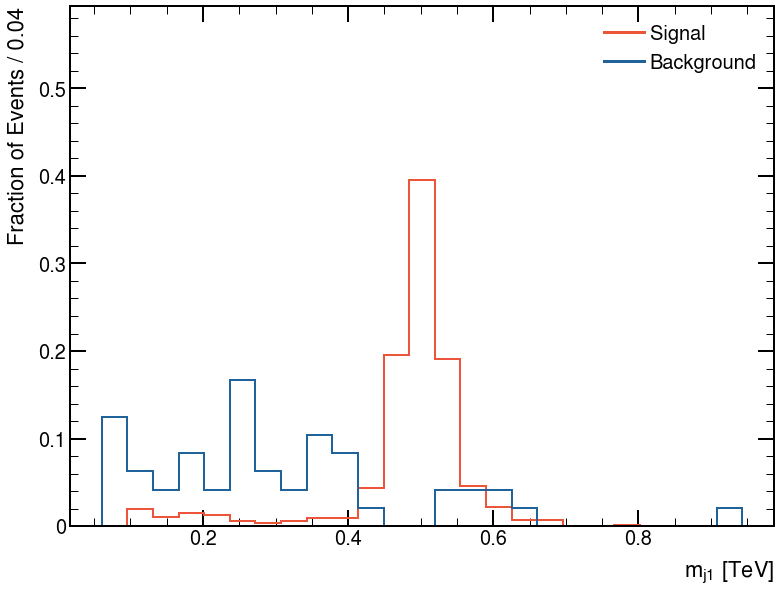

In [134]:
plotter.draw("m1", xlabel="$m_{j1}$ [TeV]")

[INFO] Using deduced bin range (0.023, 0.395)


<Axes: xlabel='$m_{j2}$ [TeV]', ylabel='Fraction of Events / 0.01'>

<Figure size 640x480 with 0 Axes>

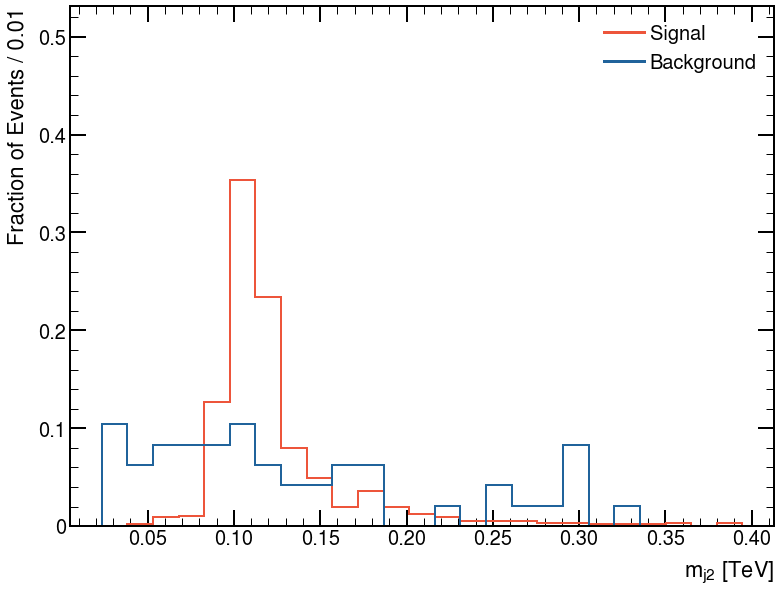

In [135]:
plotter.draw("m2", xlabel="$m_{j2}$ [TeV]")

### Check weight distributions

In [4]:
import os
import glob
import json

import numpy as np
import tensorflow as tf

from aliad.interface.tensorflow.dataset import get_ndarray_tfrecord_example_parser, apply_pipelines

dirname = "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/shuffled"
filenames = glob.glob(os.path.join(dirname, '*.tfrec'))
metadata_filenames = glob.glob(os.path.join(dirname, '*metadata.json'))

metadata = json.load(open(metadata_filenames[-1]))

In [5]:
parse_tfrecord_fn = get_ndarray_tfrecord_example_parser(metadata['features'])
ds = tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.AUTOTUNE)
ds = ds.map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)

In [6]:
unordered_masses = np.array(list(ds.map(lambda x: x['param_masses_unordered'])))
ordered_masses = np.array(list(ds.map(lambda x: x['param_masses_ordered'])))
labels = np.array(list(ds.map(lambda x: x['label'][0])))
weights = np.array(list(ds.map(lambda x: x['weight'][0])))
weights_merged = np.array(list(ds.map(lambda x: x['weight_merged'][0])))

2023-12-06 12:44:30.613309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [106]
	 [[{{node Placeholder/_0}}]]
2023-12-06 12:44:30.613758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [106]
	 [[{{node Placeholder/_0}}]]
2023-12-06 12:59:03.989553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [106]
	

In [7]:
ordered_masses[labels==0]

array([[450., 300.],
       [450., 400.],
       [350., 150.],
       ...,
       [550., 100.],
       [600., 250.],
       [350.,  50.]])

In [8]:
weight_matrix = {}
merged_weight_matrix = {}
count_matrix = {}
merged_count_matrix = {}
# mass from 50 to 600 GeV at 50 GeV interval
mass_grid = np.arange(1, 13)*50
for label, key in [(0, 'bkg'), (1, 'sig')]:
    label_idx = labels == label
    label_unordered_masses = unordered_masses[label_idx]
    label_ordered_masses = ordered_masses[label_idx]
    label_weights = weights[label_idx]
    label_weights_merged = weights_merged[label_idx]
    weight_matrix[key] = {}
    merged_weight_matrix[key] = {}
    count_matrix[key] = {}
    merged_count_matrix[key] = {}
    for m1 in mass_grid:
        weight_matrix[key][m1] = {}
        merged_weight_matrix[key][m1] = {}
        count_matrix[key][m1] = {}
        merged_count_matrix[key][m1] = {}
        for m2 in mass_grid:
            print(f"m1 = {m1}, m2 = {m2}")
            unordered_mass_idx = (label_unordered_masses[:, 0] == m1) & (label_unordered_masses[:, 1] == m2)
            ordered_mass_idx = (label_ordered_masses[:, 0] == m1) & (label_ordered_masses[:, 1] == m2)
            weight_matrix[key][m1][m2] = label_weights[unordered_mass_idx].sum()
            count_matrix[key][m1][m2] = unordered_mass_idx.sum()
            merged_weight_matrix[key][m1][m2] = label_weights_merged[ordered_mass_idx].sum()
            merged_count_matrix[key][m1][m2] = ordered_mass_idx.sum()

m1 = 50, m2 = 50
m1 = 50, m2 = 100
m1 = 50, m2 = 150
m1 = 50, m2 = 200
m1 = 50, m2 = 250
m1 = 50, m2 = 300
m1 = 50, m2 = 350
m1 = 50, m2 = 400
m1 = 50, m2 = 450
m1 = 50, m2 = 500
m1 = 50, m2 = 550
m1 = 50, m2 = 600
m1 = 100, m2 = 50
m1 = 100, m2 = 100
m1 = 100, m2 = 150
m1 = 100, m2 = 200
m1 = 100, m2 = 250
m1 = 100, m2 = 300
m1 = 100, m2 = 350
m1 = 100, m2 = 400
m1 = 100, m2 = 450
m1 = 100, m2 = 500
m1 = 100, m2 = 550
m1 = 100, m2 = 600
m1 = 150, m2 = 50
m1 = 150, m2 = 100
m1 = 150, m2 = 150
m1 = 150, m2 = 200
m1 = 150, m2 = 250
m1 = 150, m2 = 300
m1 = 150, m2 = 350
m1 = 150, m2 = 400
m1 = 150, m2 = 450
m1 = 150, m2 = 500
m1 = 150, m2 = 550
m1 = 150, m2 = 600
m1 = 200, m2 = 50
m1 = 200, m2 = 100
m1 = 200, m2 = 150
m1 = 200, m2 = 200
m1 = 200, m2 = 250
m1 = 200, m2 = 300
m1 = 200, m2 = 350
m1 = 200, m2 = 400
m1 = 200, m2 = 450
m1 = 200, m2 = 500
m1 = 200, m2 = 550
m1 = 200, m2 = 600
m1 = 250, m2 = 50
m1 = 250, m2 = 100
m1 = 250, m2 = 150
m1 = 250, m2 = 200
m1 = 250, m2 = 250
m1 = 250, 

In [9]:
import pandas as pd
dfs_weight_matrix = {}
dfs_merged_weight_matrix = {}
dfs_count_matrix = {}
dfs_merged_count_matrix = {}
for key in ['sig', 'bkg']:
    dfs_weight_matrix[key] = pd.DataFrame(weight_matrix[key])
    dfs_count_matrix[key] = pd.DataFrame(count_matrix[key])
    dfs_merged_weight_matrix[key] = pd.DataFrame(merged_weight_matrix[key])
    dfs_merged_count_matrix[key] = pd.DataFrame(merged_count_matrix[key])

<Figure size 640x480 with 0 Axes>

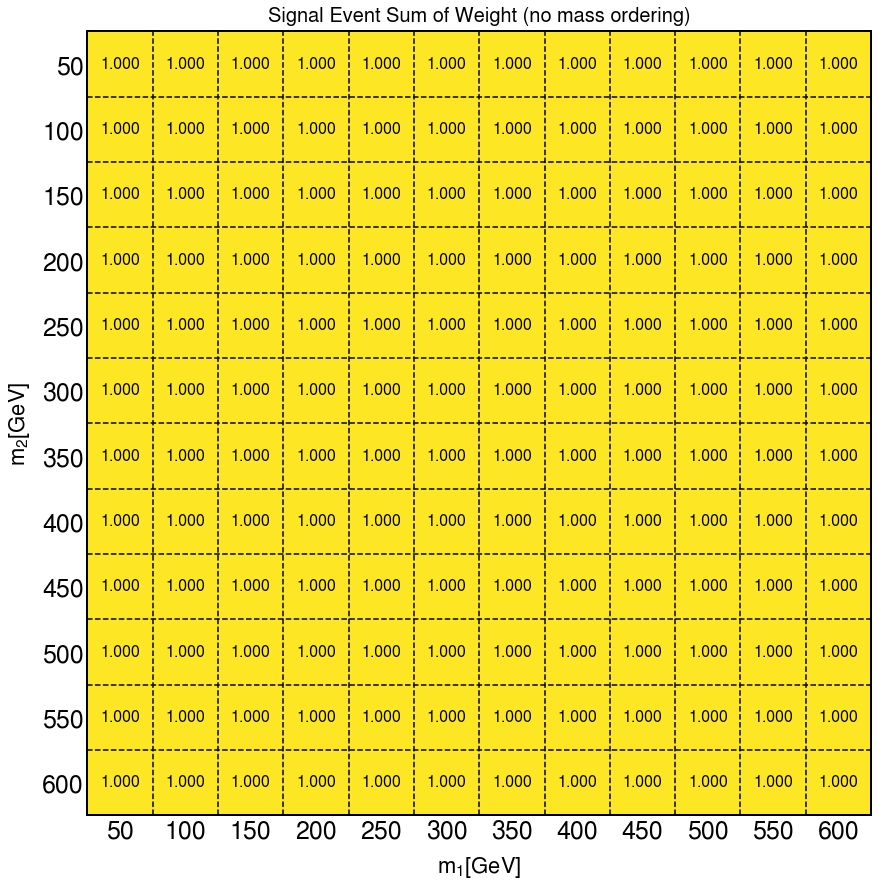

<Figure size 640x480 with 0 Axes>

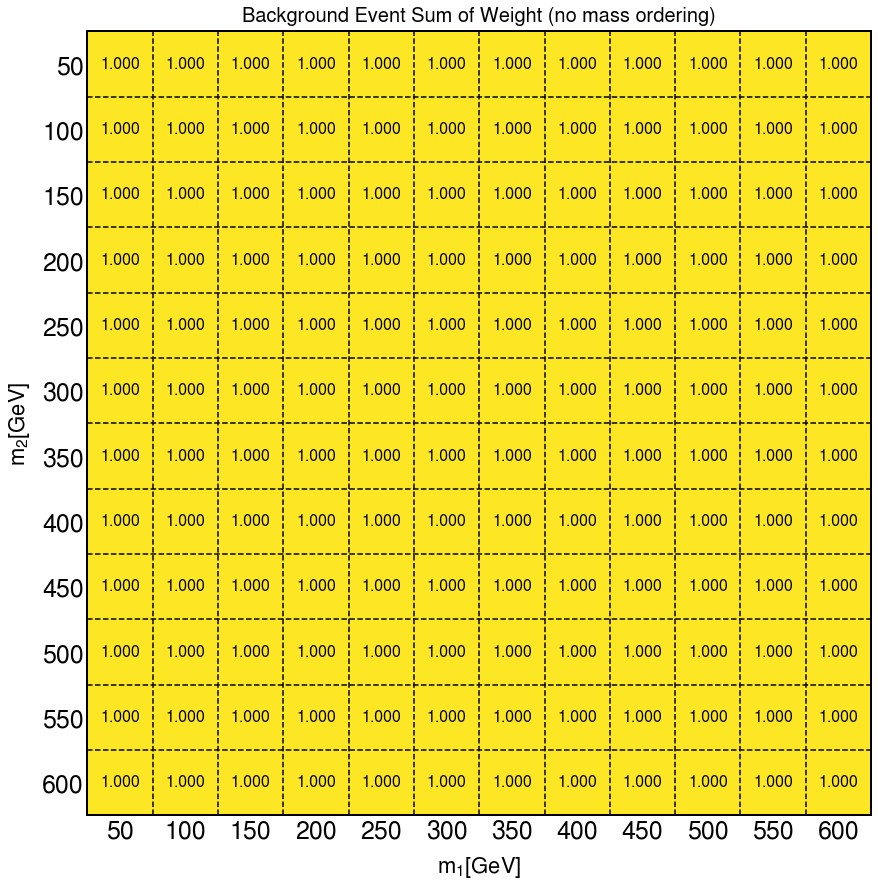

<Figure size 640x480 with 0 Axes>

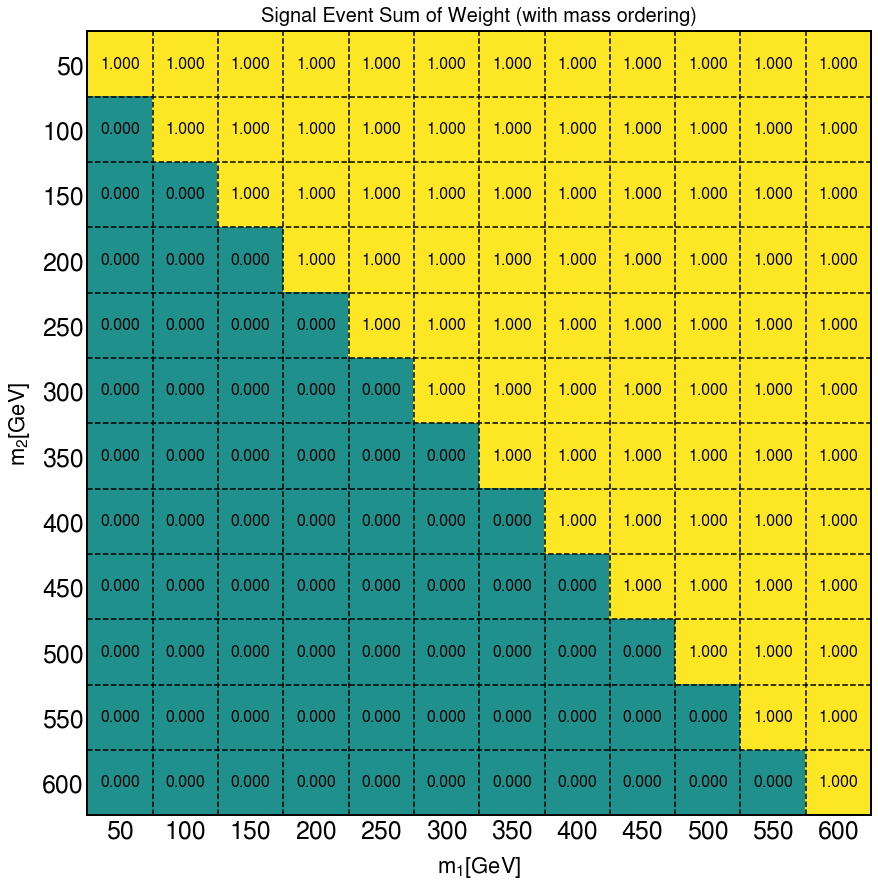

<Figure size 640x480 with 0 Axes>

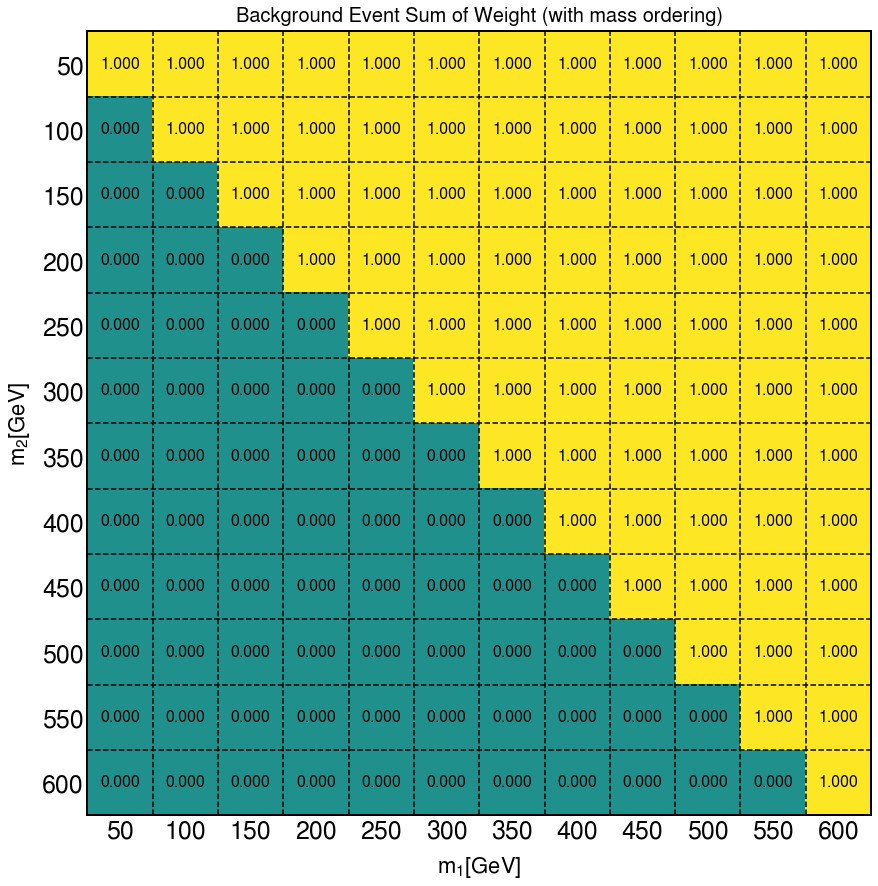

<Figure size 640x480 with 0 Axes>

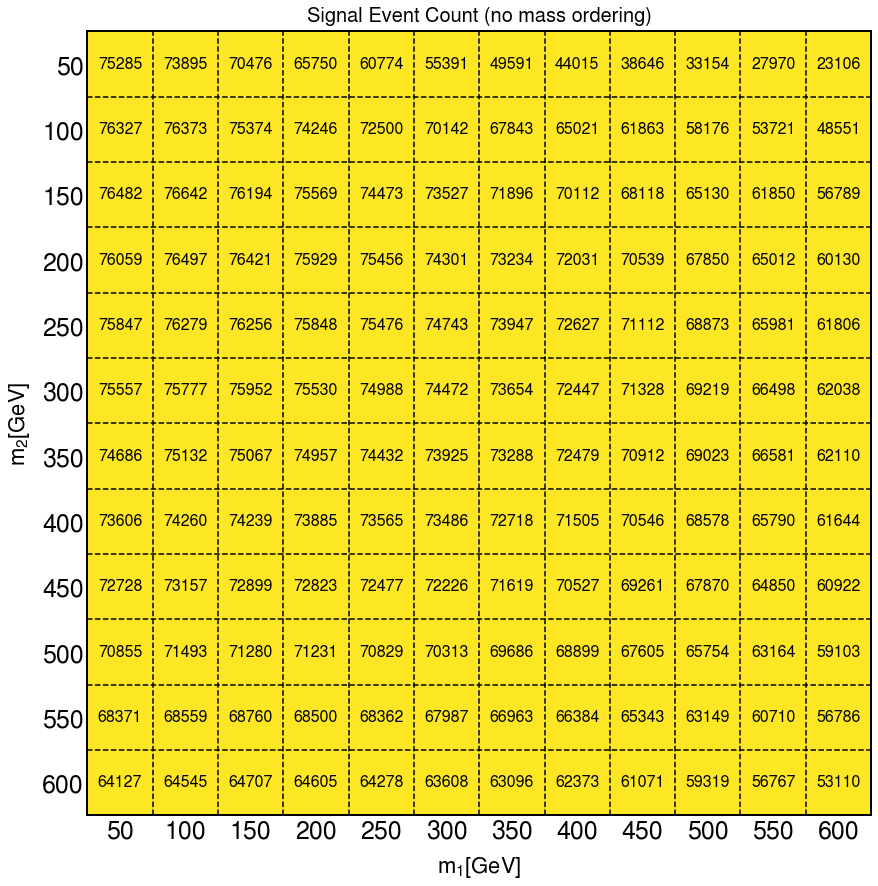

<Figure size 640x480 with 0 Axes>

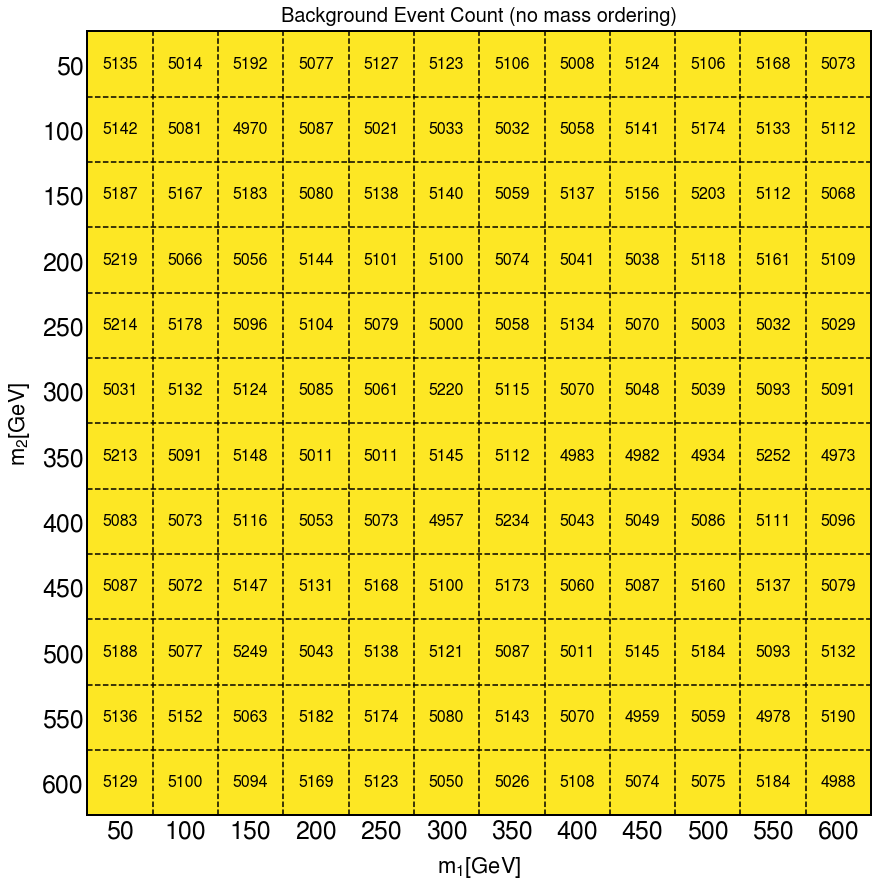

<Figure size 640x480 with 0 Axes>

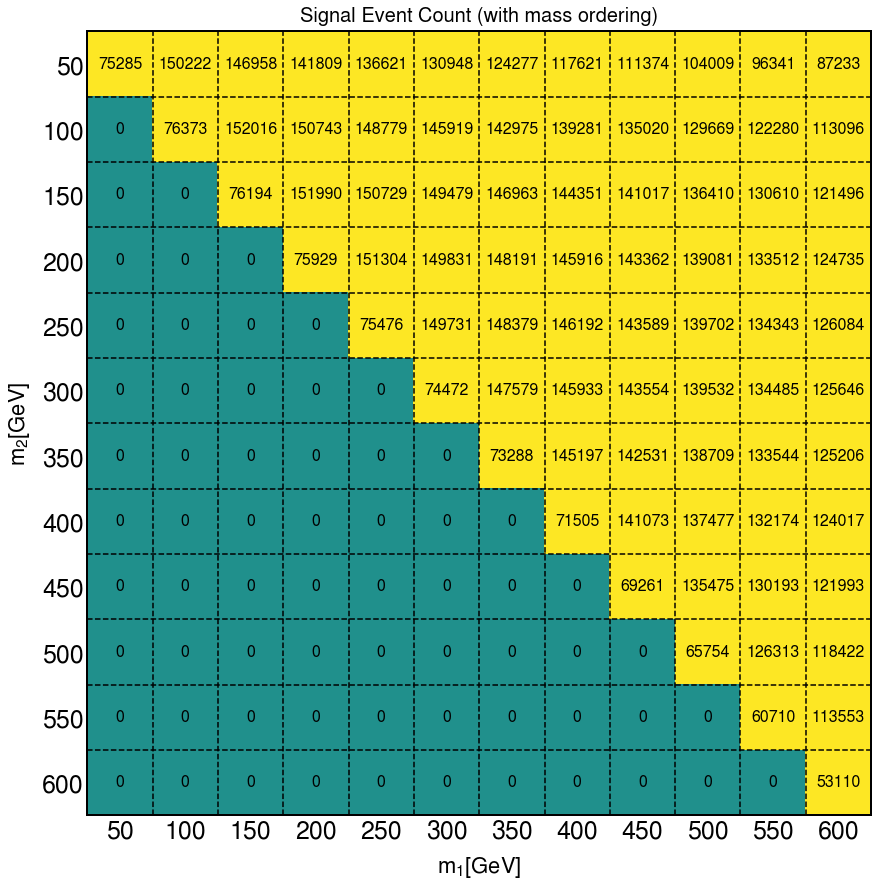

<Figure size 640x480 with 0 Axes>

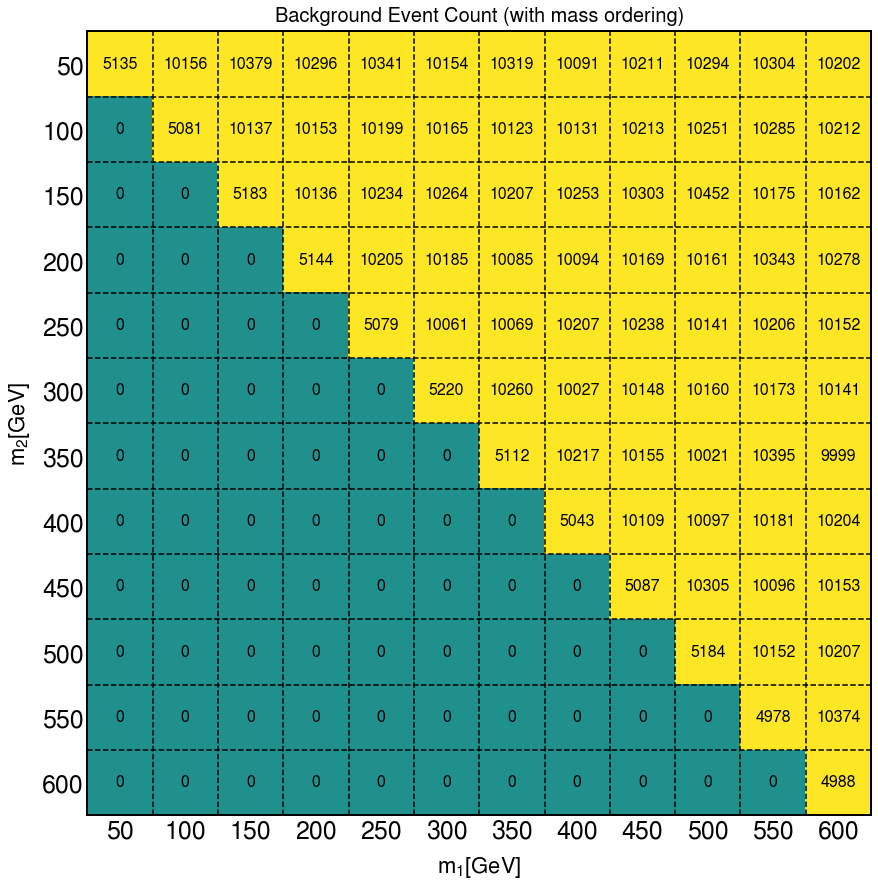

In [11]:
from quickstats.plots import CorrelationPlot
import matplotlib.pyplot as plt
dfs = {
    'weight': dfs_weight_matrix,
    'merged_weight': dfs_merged_weight_matrix,
    'count': dfs_count_matrix,
    'merged_count': dfs_merged_count_matrix
}
title_text = {
    'sig': 'Signal Event',
    'bkg': 'Background Event'
}
title_text_2 = {
    'weight': 'no mass ordering',
    'merged_weight': 'with mass ordering',
    'weight': 'no mass ordering',
    'merged_count': 'with mass ordering',
}
for scenario in dfs:
    for key in ['sig', 'bkg']:
        df = dfs[scenario][key]
        plotter = CorrelationPlot(df)
        title = 'Signal Event' if key == 'sig' else 'Background Event'
        title += ' '
        title += 'Sum of Weight' if 'weight' in scenario else 'Count'
        title += ' '
        title += '(no mass ordering)' if 'merged' not in scenario else '(with mass ordering)'
        value_precision = 3 if 'weight' in scenario else 0
        ax = plotter.draw(cmap='viridis', xlabel_rotation=0, xlabelpos='bottom',
                          xlabel='$m_1 [GeV]$', ylabel='$m_2 [GeV]$',
                          title=title, value_precision=value_precision)
        plt.show()